Methods of Machine Learning and Intellectual Analysis of Data (Learning course) \
Bohdan Pavlyshenko (https://www.linkedin.com/in/bpavlyshenko/) \
Youtube video: https://www.youtube.com/watch?v=hc12uAe2gdM&list=PLMQt7tnruMvF1jetHNUKjMtHKSp78H2bb&index=10

# Bayessian Regression (Rossmann Store Sales)

Used resource:\
https://www.kaggle.com/c/rossmann-store-sales

In [1]:
#!pip install pystan

In [2]:
import pandas as pd
import numpy as np
import random
import stan
import nest_asyncio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV,Lasso, LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'stan'

In [8]:
google_colab=True

if(google_colab):
    from google.colab import drive
    drive.mount('/content/drive')
    gdrive_dir='/content/drive/MyDrive/Colab Notebooks/pystan/'
else:
    gdrive_dir=''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir=gdrive_dir+"data/"

In [11]:
train_df=pd.read_csv(data_dir+'rossm_train_df.csv')
test_df=pd.read_csv(data_dir+'rossm_test_df.csv')
train_df.Date=pd.to_datetime(train_df.Date)
test_df.Date=pd.to_datetime(test_df.Date)

In [12]:
train_df.Store.unique()[:10]

array([ 7, 28, 44, 47, 62, 65, 73, 77, 78, 80])

In [13]:
store=65

In [14]:
train_df=train_df[train_df.Store==store]
test_df=test_df[test_df.Store==store]

In [15]:
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [16]:
train_df.shape

(730, 18)

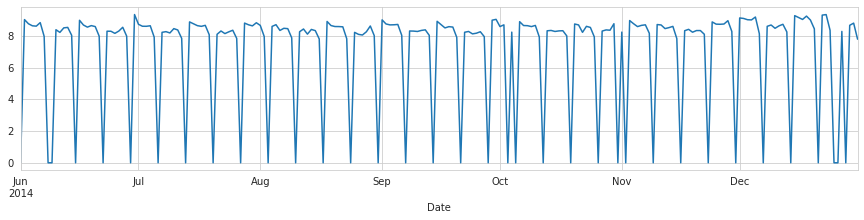

In [17]:
_=train_df.set_index('Date')['2014-05':].logSales.plot(figsize=(15,3))

In [46]:
numerical_features = [ 'Open','Promo','SchoolHoliday']
categorical_features = [  'weekday', 'month']
target = 'logSales'

In [19]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_enc=enc.fit_transform(train_df[categorical_features])
test_enc=enc.transform(test_df[categorical_features])
categorical_feat_enc=enc.get_feature_names_out(categorical_features)
train_enc_df=pd.DataFrame(train_enc,columns=categorical_feat_enc)
test_enc_df=pd.DataFrame(test_enc,columns=categorical_feat_enc)
X_train_df=pd.concat([train_df[numerical_features], train_enc_df], axis=1)
X_test_df=pd.concat([test_df[numerical_features], test_enc_df], axis=1, ignore_index=True)

In [20]:
X_train_df.shape

(730, 24)

In [21]:
features=numerical_features+list(categorical_feat_enc)
features

['Open',
 'Promo',
 'SchoolHoliday',
 'logMonthSales',
 'CompetitionDistance',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12']

In [22]:
X_train = X_train_df.values
X_test = X_test_df.values
y_train = train_df[target].values
y_test = test_df[target].values

In [23]:
scaler = StandardScaler()
X_train_st=scaler.fit_transform(X_train)
X_test_st=scaler.transform(X_test)

In [25]:
!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
nest_asyncio.apply()

In [27]:
stan_model = """
data {
    int<lower=1> n;
    int<lower=1> n_train;
    int<lower=1> k;
    vector[n_train] y_train;
    matrix[n_train, k] x_train;
    matrix[n, k] x;
    real par_a_sigma;
    real par_beta_sigma;
    real par_y_sigma;
}

parameters {
    vector[k] beta;
    real<lower=0> sigma;  
    real a;
}
  
model {
a ~ normal(0,par_a_sigma);
beta ~ normal(0,par_beta_sigma);
sigma ~ cauchy(0,par_y_sigma);
y_train ~ normal(a+x_train*beta, sigma);
}

generated quantities {
  vector[n] pred;
  for (i in 1:n){
  pred[i]=  normal_rng(a+x[i,:]*beta, sigma);
  }
  }
"""


In [28]:
y_mean=y_train.mean()
y_std=y_train.std()
y_train_st=((y_train-y_mean)/y_std)

In [29]:
y_train_st.shape, X_train.shape[0]

((730,), 730)

In [30]:
par_a_sigma=1
par_beta_sigma=1
par_y_sigma=1
data = {
    'n_train': X_train.shape[0],
    'k': X_train.shape[1],
    'x_train':X_train_st,
    'y_train': y_train_st,
    'n': X_test_st.shape[0],
    'x': X_test_st,
    'par_a_sigma':par_a_sigma,
    'par_beta_sigma':par_beta_sigma,
    'par_y_sigma':par_y_sigma
      }
stan_model =  stan.build(stan_model, data=data, random_seed=1)

Building...



Building: 29.3s, done.Messages from stanc:


In [31]:
num_samples=3000
fit = stan_model.sample(num_chains=3, num_samples=num_samples,  num_warmup=300, save_warmup=False)

Sampling:   0%
Sampling:   0% (1/9900)
Sampling:   0% (2/9900)
Sampling:   1% (101/9900)
Sampling:   2% (200/9900)
Sampling:   3% (300/9900)
Sampling:   4% (400/9900)
Sampling:   5% (501/9900)
Sampling:   6% (602/9900)
Sampling:   7% (701/9900)
Sampling:   8% (800/9900)
Sampling:   9% (900/9900)
Sampling:  10% (1000/9900)
Sampling:  11% (1100/9900)
Sampling:  12% (1200/9900)
Sampling:  13% (1300/9900)
Sampling:  14% (1400/9900)
Sampling:  15% (1500/9900)
Sampling:  16% (1600/9900)
Sampling:  17% (1700/9900)
Sampling:  18% (1800/9900)
Sampling:  19% (1900/9900)
Sampling:  20% (2000/9900)
Sampling:  21% (2100/9900)
Sampling:  22% (2200/9900)
Sampling:  23% (2300/9900)
Sampling:  24% (2400/9900)
Sampling:  25% (2500/9900)
Sampling:  26% (2600/9900)
Sampling:  27% (2700/9900)
Sampling:  28% (2800/9900)
Sampling:  29% (2900/9900)
Sampling:  30% (3000/9900)
Sampling:  31% (3100/9900)
Sampling:  32% (3200/9900)
Sampling:  33% (3300/9900)
Sampling:  34% (3400/9900)
Sampling:  35% (3500/9900)
S

In [32]:
pred_st=fit['pred']
pred=pred_st*y_std+y_mean

In [35]:
test_df['pred_mean']=pred.mean(axis=1)
test_df['pred_q05']=np.quantile(pred,q=0.05,axis=1)
test_df['pred_q95']=np.quantile(pred,q=0.95,axis=1)

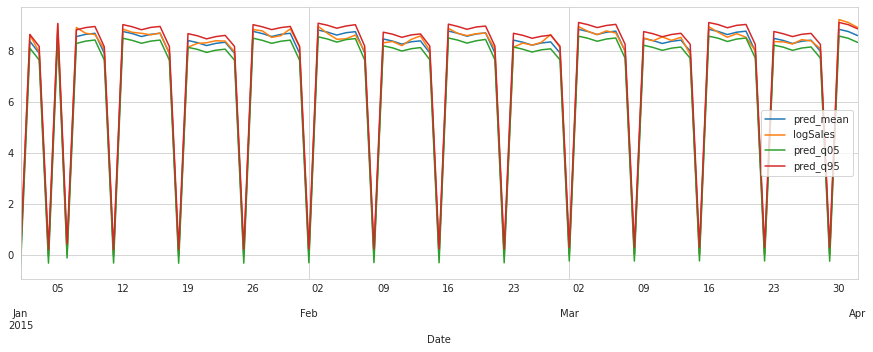

In [40]:
_=test_df.set_index('Date')[:'2015-04-01'][['pred_mean','logSales','pred_q05','pred_q95']].plot(figsize=(15,5))

In [44]:
beta=fit['beta']
beta_mean=beta.mean(axis=1)
beta_std=beta.std(axis=1)
beta_df=pd.DataFrame({'features':features, 'beta_mean':beta_mean,'beta_std':beta_std})
beta_df

,features,beta_mean,beta_std,var_coef
0,Open,1.002261,0.004356,0.004347
1,Promo,0.053489,0.002137,0.039953
2,SchoolHoliday,0.005151,0.002228,0.432520
3,logMonthSales,-0.008142,1.004340,123.346717
4,CompetitionDistance,0.020416,0.992248,48.601619
5,weekday_0,0.005030,0.380275,75.607733
6,weekday_1,-0.004031,0.381817,94.711646
7,weekday_2,-0.016988,0.381811,22.475074
8,weekday_3,-0.007275,0.380284,52.271955
9,weekday_4,-0.002714,0.380278,140.119698


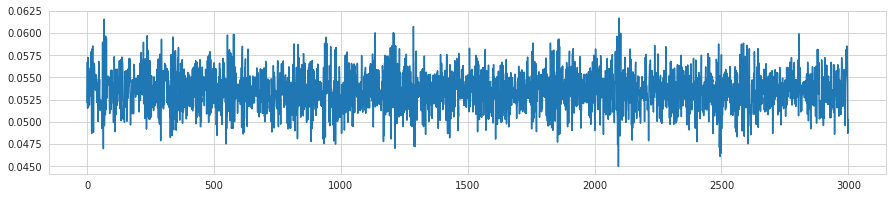

In [51]:
_=pd.Series(beta[1,:3000]).plot(figsize=(15,3))

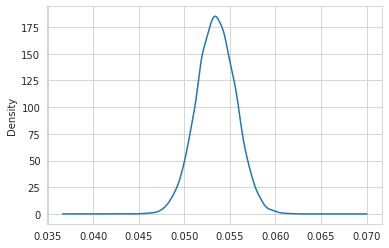

In [45]:
pd.Series(beta[1]).plot(kind='density')

In [49]:
test_rmse = np.round(mean_squared_error(test_df[target], test_df['pred_mean'], squared=False),3)
print(f'test RMSE={test_rmse}')

test RMSE=0.153
